# Import modules

In [70]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.markers import MarkerStyle
from mpl_toolkits.mplot3d import Axes3D
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import add_dummy_feature, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.base import clone
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Import dataset

In [2]:
df = pd.read_csv('final_df.csv', index_col=0).set_index('company_name').drop('as_of_date', axis=1)
df.head()

,followers_count,employees_on_platform,industry,checkins,were_here_count,likes,talking_about_count,stock_symbol
company_name,,,,,,,,
1800petmeds,1771,121,Retail,41,30,159898,16831,1
1st source bank,3523,921,Banking,191,0,5316,1048,1
21 club,610,167,Restaurants,9831,9831,6994,2279,1
3m,852348,58944,Mechanical or Industrial Engineering,3416,0,4497193,39516,1
aar corp.,17350,3712,Airlines/Aviation,174,174,1742,346,0


## Use logistic numbers of numerical columns

In [3]:
numerical_columns = df.drop(['industry', 'stock_symbol'], axis=1).columns.to_list()
for col in numerical_columns:
    df.loc[:, col] = np.log10(df.loc[:, col].replace(0, 0.001))
df.head()

,followers_count,employees_on_platform,industry,checkins,were_here_count,likes,talking_about_count,stock_symbol
company_name,,,,,,,,
1800petmeds,3.248219,2.082785,Retail,1.612784,1.477121,5.203843,4.226110,1
1st source bank,3.546913,2.964260,Banking,2.281033,-3.000000,3.725585,3.020361,1
21 club,2.785330,2.222716,Restaurants,3.992598,3.992598,3.844726,3.357744,1
3m,5.930617,4.770440,Mechanical or Industrial Engineering,3.533518,-3.000000,6.652942,4.596773,1
aar corp.,4.239299,3.569608,Airlines/Aviation,2.240549,2.240549,3.241048,2.539076,0


## Data correlation

In [4]:
corr_matrix = df.corr()

In [5]:
corr_matrix['stock_symbol'].sort_values(ascending=False)

stock_symbol             1.000000
likes                    0.178972
talking_about_count      0.136619
followers_count          0.010140
were_here_count         -0.006991
employees_on_platform   -0.022097
checkins                -0.036436
Name: stock_symbol, dtype: float64

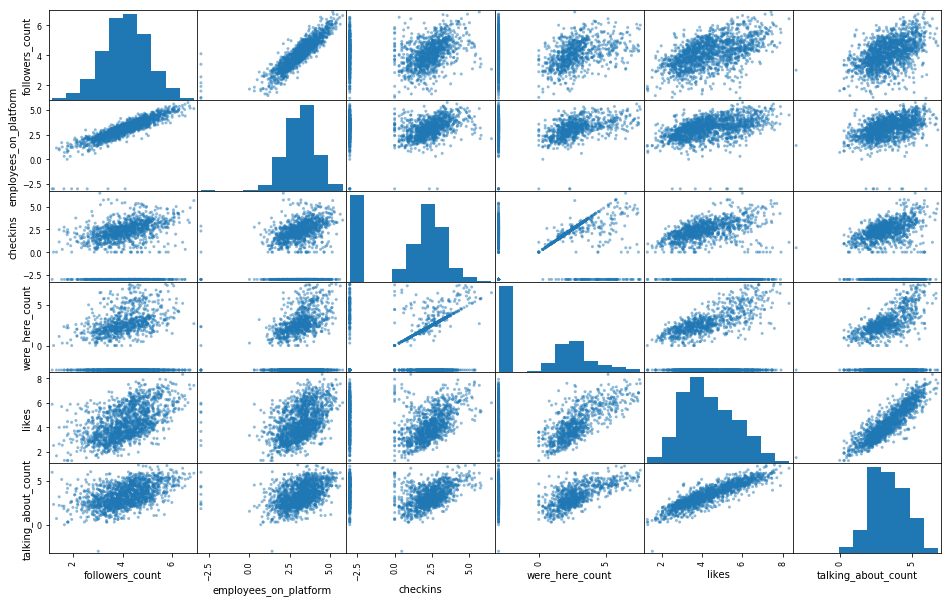

In [6]:
axarr = scatter_matrix(df.drop('stock_symbol', axis=1), figsize=(16,10))

## Transformation

In [7]:
df_dummy = pd.concat([df, pd.get_dummies(df.industry, prefix='industry_')], axis=1).drop('industry',axis=1)

In [8]:
X = df_dummy.drop('stock_symbol', axis=1)
y = df_dummy.stock_symbol

In [9]:
mm = MinMaxScaler()
X = pd.DataFrame(mm.fit_transform(X), columns=X.columns)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=17)

# Training

## Decision Tree Classifier

In [11]:
dtc = DecisionTreeClassifier()
param_grid = [{
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6],
    'max_leaf_nodes': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [0.1, 0.5, 1.0]
    }]
grid_search = GridSearchCV(dtc, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_dtc = grid_search.best_estimator_
print(best_dtc)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=4, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=0.1, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


## Random Forest Classifier

In [12]:
rfc = RandomForestClassifier()
param_grid = [
    {'n_estimators': [1, 10, 100],
     'criterion': ['gini', 'entropy'],
     'max_depth': [2, 3, 4, 5],
     'random_state': [17]
    }]
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_rfc = grid_search.best_estimator_
print(best_rfc)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=17, verbose=0, warm_start=False)


## SGDClassifier

In [13]:
sgd = SGDClassifier()
param_grid = [
    {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
     'penalty': ['l1'],
     'alpha': [0.0001, 0.001, 0.01],
     'l1_ratio': [0.3, 0.5, 0.7],
     'max_iter': [100, 1000, 10000],
     'tol': [0.001],
     'shuffle': [True],
     'validation_fraction': [0.1, 0.3],
     'early_stopping': [True, False],
     'n_jobs': [6],
    }]
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_sgd = grid_search.best_estimator_
print(best_sgd)

SGDClassifier(alpha=0.01, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.7, learning_rate='optimal', loss='modified_huber',
       max_iter=1000, n_iter=None, n_iter_no_change=5, n_jobs=6,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       tol=0.001, validation_fraction=0.3, verbose=0, warm_start=False)


## Cross-validation

In [14]:
print('sgd', cross_val_score(best_sgd, X_train, y_train, cv=5, scoring='f1'))
print('rfc', cross_val_score(best_rfc, X_train, y_train, cv=5, scoring='f1'))
print('dtc', cross_val_score(best_dtc, X_train, y_train, cv=5, scoring='f1'))

sgd [0.79213483 0.78551532 0.76571429 0.77994429 0.78915663]
rfc [0.78571429 0.78804348 0.7826087  0.78021978 0.78474114]
dtc [0.78378378 0.78378378 0.7826087  0.78474114 0.7826087 ]


In [15]:
preds_sgd = best_sgd.predict(X_test)
print('sgd', roc_auc_score(preds_sgd, y_test))

preds_rfc = best_rfc.predict(X_test)
print('rfc', roc_auc_score(preds_rfc, y_test))

# preds = best_dtc.predict(X_test)
# print('dtc', roc_auc_score(preds, y_test))

sgd 0.5679723502304148
rfc 0.8125


In [16]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

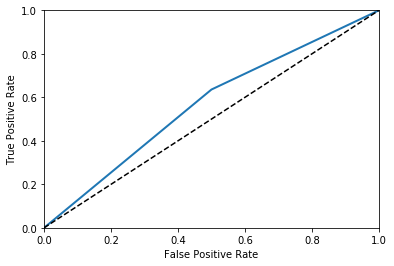

In [17]:
fpr, tpr, thresholds = roc_curve(preds_sgd, y_test)
plot_roc_curve(fpr, tpr)

# fpr, tpr, thresholds = roc_curve(preds_dtc, y_test)
# plot_roc_curve(fpr, tpr)

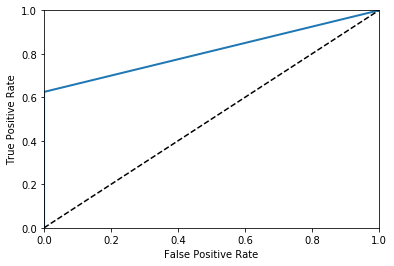

In [18]:
fpr, tpr, thresholds = roc_curve(preds_rfc, y_test)
plot_roc_curve(fpr, tpr)

## SVC

In [19]:
svc = SVC()
param_grid = [
    {'C': np.logspace(-2, 2, 4),
     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
     'degree': [3, 4],
     'tol': [0.001],
     'gamma': np.logspace(-2, 2, 4),
    }]
grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)
best_svc = grid_search.best_estimator_
print(best_svc)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=100.0, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [20]:
print('svc', cross_val_score(best_svc, X_train, y_train, cv=3, scoring='f1'))

svc [0.78373984 0.78373984 0.78303426]


company_name
atlantic capital bank                 1
ingersoll rand                        1
teradata                              1
corelogic                             1
texas roadhouse                       0
delphi                                1
eni                                   1
intrepid potash                       0
john deere                            1
simmons bank                          1
lamar advertising company             0
net element                           0
veritiv corporation                   0
kimberly-clark                        1
nutrisystem, inc.                     0
natuzzi                               1
jet aviation                          1
intersect ent, inc                    0
bradesco                              1
s&p global market intelligence        1
twitter                               1
aon benfield                          1
spotify                               1
cnh industrial                        0
taobao marketplace         

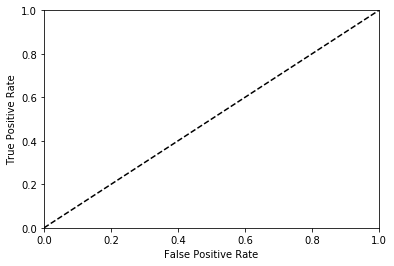

In [21]:
preds_svc = best_svc.predict(X_test)
fpr, tpr, thresholds = roc_curve(preds_svc, y_test)
plot_roc_curve(fpr, tpr)
print(y_test)

In [23]:
f1_score(preds_svc, y_test)

0.7672634271099744

## Ridge Classifier

In [24]:
rc = RidgeClassifier()
param_grid = [
    {'alpha': np.logspace(-2, 2, 4),
     'max_iter': np.logspace(2, 8, 3),
     'tol': [0.001],
     'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    }]
grid_search = GridSearchCV(rc, param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)
best_rc = grid_search.best_estimator_
print(best_rc)

RidgeClassifier(alpha=100.0, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=100.0, normalize=False,
        random_state=None, solver='auto', tol=0.001)


In [25]:
print('rc', cross_val_score(best_rc, X_train, y_train, cv=5, scoring='f1'))

rc [0.78378378 0.78378378 0.7826087  0.7826087  0.7826087 ]


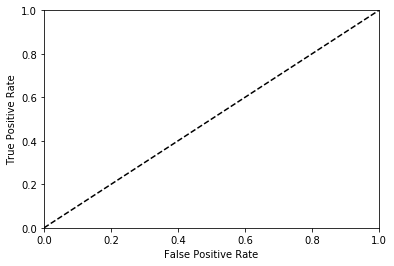

In [26]:
preds_rc = best_rc.predict(X_test)
fpr, tpr, thresholds = roc_curve(preds_rc, y_test)
plot_roc_curve(fpr, tpr)

## Plot the result of SVC

Text(0, 0.5, 'LinkedIn followers')

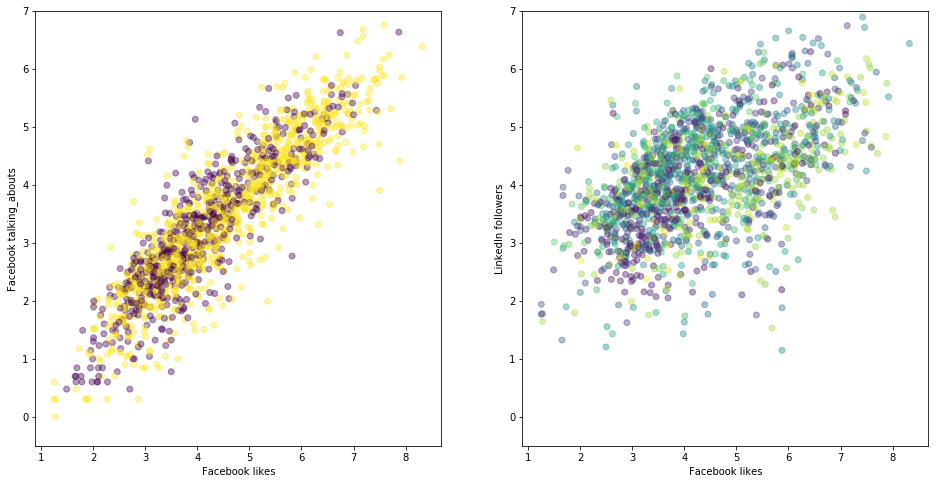

In [85]:
likes = df.likes
talking = df.talking_about_count
follower = df.followers_count
le = LabelEncoder()
colors1 = df.stock_symbol
colors2 = le.fit_transform(df.industry)
fig = plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.scatter(likes, talking, c=colors1, alpha=0.4)
plt.ylim([-0.5, 7])
plt.xlabel('Facebook likes')
plt.ylabel('Facebook talking_abouts')
plt.subplot(122)
plt.scatter(likes, follower, c=colors2, alpha=0.4)
plt.ylim([-0.5, 7])
plt.xlabel('Facebook likes')
plt.ylabel('LinkedIn followers')

Text(0.5, 0, 'LinkedIn followers')

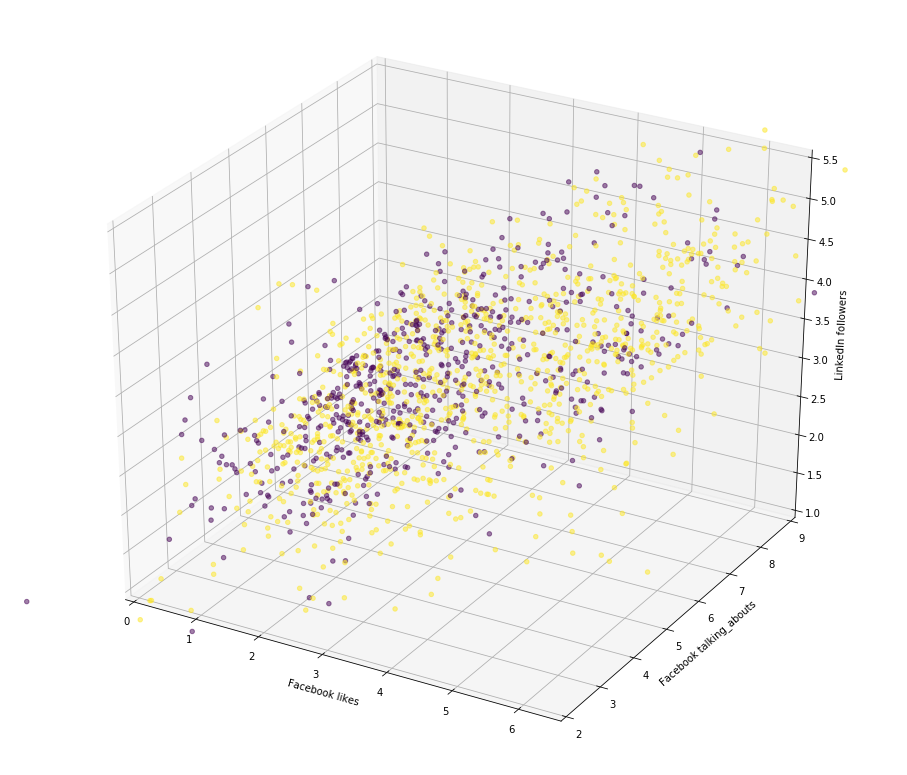

In [122]:
likes = df.likes
talking = df.talking_about_count
follower = df.followers_count
le = LabelEncoder()
colors1 = df.stock_symbol
colors2 = le.fit_transform(df.industry)
fig = plt.figure(figsize=(16, 14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=likes, ys=talking, zs=follower, c=colors1, alpha=0.5)

ax.set_xlim([0, 6.5])
ax.set_ylim([2, 9])
ax.set_zlim([1, 5.5])
ax.set_xlabel('Facebook likes')
ax.set_ylabel('Facebook talking_abouts')
ax.set_zlabel('LinkedIn followers')

## KNN

In [28]:
param_grid = [
    {'n_neighbors': [1, 5, 10],
     'leaf_size': [15, 30, 60]
    }]
grid_search = GridSearchCV(KNN(), param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)
best_knn = grid_search.best_estimator_
print(best_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=15, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')


In [29]:
print('knn', cross_val_score(best_knn, X_train, y_train, cv=5, scoring='f1'))

knn [0.73927393 0.75471698 0.7114094  0.70234114 0.7483871 ]


In [ ]:
preds_knn = best_knn.predict(X_test)
fpr, tpr, thresholds = roc_curve(preds_knn, y_test)
plot_roc_curve(fpr, tpr)